<a href="https://jupyterhub.user.eopf.eodc.eu/hub/user-redirect/git-pull?repo=https://github.com/atsiokanos/eopf-101&branch=6_a_general_overview_of_the_topic_gww&urlpath=lab/tree/eopf-101/65_gww.ipynb" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

Water reservoirs are essential for water supply, energy production, and irrigation. However, population growth, economic expansion, and climate change are increasing pressure on these resources, affecting water availability and raising the risk of droughts and floods. Reliable monitoring of reservoirs is critical to ensure sustainable water management and water security.  

[Global Water Watch (GWW)](https://www.globalwaterwatch.earth/) is a platform developed by [Deltares](https://www.deltares.nl/en) and supported by Google.org, the Water, Peace, and Security Partnership, and the European Space Agency (ESA). It provides near-real-time, globally accessible information on reservoirs using Earth Observation data, helping stakeholders monitor changes in water extent and manage resources more effectively. A detailed description of GWW methods is available in [this publication](https://www.nature.com/articles/s41598-022-17074-6).  

In this notebook, we **implement parts of the GWW algorithms** to estimate water extent for a single reservoir: **Mita Hills in Zambia**. Although the original GWW algorithm uses **Landsat 7 & 8** as well as **Sentinel-2**, we focus only on **Sentinel-2 (L1C) imagery** here for simplicity.  



### What we will learn


- 💧 Compute the Modified Normalized Difference Water Index (MNDWI) and understand its role in highlighting water bodies.  
- 🧩 Apply parts of the GWW algorithm to generate water masks and extract the largest connected water body.  
- 📈 Estimate and analyze reservoir water extent over time using Earth observation imagery.


<hr>

#### Import libraries

In [1]:
# Parallel computing and large data handling
import dask                                  
from dask.distributed import Client          
import pandas as pd

# Data access
from pystac_client import Client as StacClient   # Query EO datasets via STAC API
from pystac import MediaType                     # Identify asset media types (e.g., ZARR)

# Coordinate reference systems and projection
from pyproj import CRS, Transformer              # Convert AOI from geographic to projected (UTM)
from rasterio.enums import Resampling           # Resampling method for reprojection
import xarray as xr                        
import rioxarray

# Visualization
import matplotlib.pyplot as plt                


#### Helper functions

This notebook utilizes a set of helper functions from the Python file `gww_utils.py` to handle key tasks, including loading and preprocessing the datasets, computing water masks using the GWW algorithm, and calculating reservoir areas. The main logic of each function is outlined in the notebook prior to its use, and the full code can be inspected in `gww_utils.py`.


In [2]:
from gww_utils import (
    list_found_elements,
    load_datatrees,
    preprocess_datatree,
    gww,
    largest_connected_component,
    compute_area_km2,
    compute_quality_score,
    keep_most_clean,
)

<hr>

## Section 1 - Data Preparation


Overview of Section 1:

[1.1 - Initial Setting and Data Connection](#11---initial-settings-and-data-connection)  
[1.2 - Load and Preprocess Data](#12---load-and-preprocess-data)


### 1.1 Initial settings and data connection

Initiate dask client for parallel processing

In [3]:
# Start dask client 
client = Client()  # local cluster, can monitor dashboard
print(client)
print(client.dashboard_link)

<Client: 'tcp://127.0.0.1:60006' processes=4 threads=12, memory=15.64 GiB>
http://127.0.0.1:8787/status


Define settings and retrieve Sentinel-2 L1C data from EOPF STAC Catalog

In [6]:
# Define AOI bbox coordinates (minx, miny, maxx, maxy) in EPSG:4326 (WGS 84)
minx, miny, maxx, maxy = 28.99253107, -14.2426452, 29.17046702, -13.95317373

# Define time range
#start_date = "2025-06-01"
# this has a very dry wrong scene start_date = "2025-01-01" "2025-01-25"
start_date = "2024-01-01" 
# end_date = "2019-07-29"
end_date = "2024-12-31"
# end_date = "2025-06-27"
cloud_cutoff_percentile = 35
# Define collection
collection = "sentinel-2-l1c"

# Connect to EOPF STAC Catalog
eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/"
eopf_catalog = StacClient.open(url=eopf_stac_api_root_endpoint)

# Start a search
s2_collection = eopf_catalog.search(
    collections=collection,
    bbox=(minx, miny, maxx, maxy),
    datetime=f"{start_date}T00:00:00Z/{end_date}T23:59:59Z",
    query = {'eo:cloud_cover': {'lte': cloud_cutoff_percentile}}
)

# List found scenes
scenes = list_found_elements(s2_collection)
print(f"Total items found for collection {collection} over AOI:", len(scenes[0]))

# Retrieve ZARR URLs/paths
S2l1c_coll = eopf_catalog.get_collection(collection)
items_loc_url = []

for item_id in scenes[0]:
    item = S2l1c_coll.get_item(id=item_id)
    item_assets = item.get_assets(media_type=MediaType.ZARR)
    cloud_storage_url = item_assets['product'].href
    items_loc_url.append(cloud_storage_url)

Total items found for collection sentinel-2-l1c over AOI: 55


### 1.2 Load and Preprocess Data

For loading the datasets, we use the `load_dataset` function, which leverages **xarray’s `open_dataset`** with the **"eopf-zarr"** engine. This approach allows us to load only the desired bands and specify the target resolution (20 m). This is particularly convenient for **Sentinel-2 L1C** data, where bands are stored at different native resolutions — for example, the green band at 10 m and the SWIR band at 20 m. The resampling is handled internally by the *eopf-zarr* engine, ensuring a consistent resolution across all bands. Another advantage is that we can directly create a single **xarray.Dataset** without loading the entire data tree into memory.

Note that in the following cell loading is done lazily using `dask.delayed`, which builds a Dask task graph. Execution of this graph triggers **parallel processing** of all dataset loading tasks, improving efficiency and reducing memory usage.


In [7]:
# Load datatrees in parallel using dask.delayed
delayed_datatrees = [dask.delayed(load_datatrees)(path) for path in items_loc_url]
datatrees = dask.compute(*delayed_datatrees)

In [8]:
# get the scenes crs from the attributes of the first datatree
crs_code = datatrees[0].attrs["other_metadata"]["horizontal_CRS_code"]  
print("Scene CRS code:", crs_code)

# Build CRS object and transformer from WGS84
scene_crs = CRS.from_user_input(crs_code)
project_to_scene = Transformer.from_crs("EPSG:4326", scene_crs, always_xy=True)

# Transform bounding box to scene CRS 
minx_utm, miny_utm = project_to_scene.transform(minx, miny)
maxx_utm, maxy_utm = project_to_scene.transform(maxx, maxy)

Scene CRS code: EPSG:32735


In [ ]:
delayed_datasets = [
    dask.delayed(preprocess_datatree)(
        dtree,
        minx_utm,
        miny_utm,
        maxx_utm,
        maxy_utm,
        crs_code
    )
    for dtree in datatrees
]

datasets = dask.compute(*delayed_datasets)

In [11]:
data_cube = xr.concat(datasets, dim="time")
# Sort by time
data_cube = data_cube.sortby("time")

In [12]:
# Apply to your data cube along 'time' dimension
# Here 'green' is (time, y, x)
quality_scores = xr.apply_ufunc(
    compute_quality_score,
    data_cube["green"],
    input_core_dims=[["y", "x"]],
    vectorize=True,
    kwargs={"percentile": 75},
    dask="parallelized",
    output_dtypes=[float],
    output_core_dims=[[]]  # scalar per time
)

In [13]:
data_cube["quality_score"] = quality_scores

In [14]:
data_cube

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 55, y: 1593, x: 975)
Coordinates:
  * time           (time) datetime64[s] 440B 2024-01-29 ... 2024-12-29
    spatial_ref    int64 8B 0
  * x              (x) float32 4kB 7.15e+05 7.15e+05 ... 7.344e+05 7.345e+05
  * y              (y) float32 6kB 8.456e+06 8.456e+06 ... 8.425e+06 8.425e+06
Data variables:
    green          (time, y, x) float64 683MB 0.1231 0.1619 ... 0.122 0.1216
    swir           (time, y, x) float64 683MB dask.array<chunksize=(1, 564, 164), meta=np.ndarray>
    quality_score  (time) float64 440B 0.1103 0.2456 0.1009 ... 0.1371 0.1428

In [15]:
clean_ds = keep_most_clean(data_cube, keep_fraction=0.65)


c:\Users\tsiokano\git\eopf-101\gww_utils.py:237: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_time = ds.dims["time"]


In [16]:
clean_ds

<xarray.Dataset> Size: 870MB
Dimensions:        (time: 35, y: 1593, x: 975)
Coordinates:
  * time           (time) datetime64[s] 280B 2024-01-29 ... 2024-12-14
    spatial_ref    int64 8B 0
  * x              (x) float32 4kB 7.15e+05 7.15e+05 ... 7.344e+05 7.345e+05
  * y              (y) float32 6kB 8.456e+06 8.456e+06 ... 8.425e+06 8.425e+06
Data variables:
    green          (time, y, x) float64 435MB 0.1231 0.1619 ... 0.1731 0.1687
    swir           (time, y, x) float64 435MB dask.array<chunksize=(1, 564, 164), meta=np.ndarray>
    quality_score  (time) float64 280B 0.1103 0.1009 0.1252 ... 0.1281 0.1303

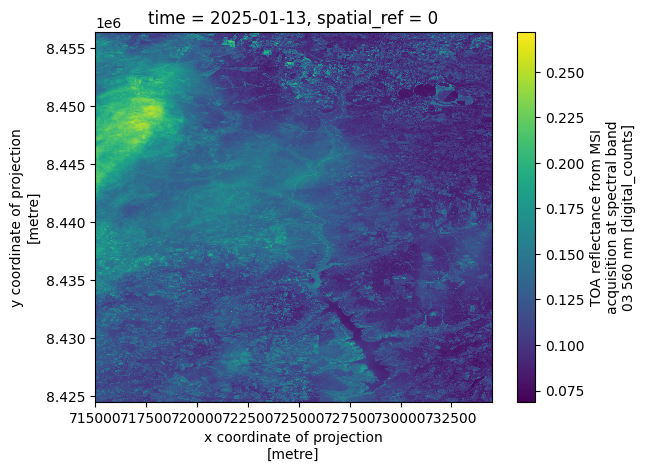

In [59]:
data_cube.sel(time="2025-01-13")["green"].plot()

While the search coordinates are in geographic coordinates (EPSG:4326), the data retrieved from the **EOPF STAC API** is in UTM coordinates. Therefore, we need to convert the AOI coordinates to UTM as well, so that we can correctly clip the data to the AOI.Additionally, individual scenes in the `datasets` do not have a time dimension.  

In the following code, we:

1. Estimate the UTM zone (using the `get_utm_zone` function; note that the UTM zone is also available in the dataset attributes).  
2. Clip each scene to the AOI bounds and rename the bands to descriptive names (`preprocess_dataset` function)
3. Stack all scenes into a single dataset with a **time dimension**, using the mean sensing time from the loaded attributes.

Finally, we have a clipped `data_cube` containing all scenes, now including a **time dimension** for the relevant bands as data variables (`time`, `lat`, `lon`). We will use this dataset in **Section 2** to perform time series analysis, namely to derive water extents and calculate the area for each scene.

<hr>

## Section 2 - Reservoir Water Extent Estimation

Overview of Section 2:

[2.1 - Compute MNDWI](#21---compute-mndwi)  
[2.2 - Integrate Water Occurrence Data (JRC)](#22---integrate-water-occurrence-data-jrc)  
[2.3 - Generate water extents (GWW Algorithm)](#23---generate-water-extents-gww-algorithm)  
[2.4 - Extract Largest Connected Component](#24---extract-largest-connected-component)  
[2.5 - Compute Reservoir Area](#25---compute-reservoir-area)


### 2.1 - Compute MNDWI



We start by computing the Modified Normalized Difference Water Index (MNDWI) using the green and SWIR bands. The MNDWI enhances the presence of water by producing high positive values for water pixels and lower or negative values for land and vegetation. This gives us a first indication of where water is located, but simple thresholding at this stage can be unreliable, especially near shorelines or in areas with shallow water or vegetation.

In [17]:
data_cube = clean_ds

In [18]:
# calculate MNDWI
green = data_cube['green']
swir = data_cube['swir']
mndwi = (green - swir) / (green + swir)


Visualize example output from Subsection 2.1

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 11.87 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


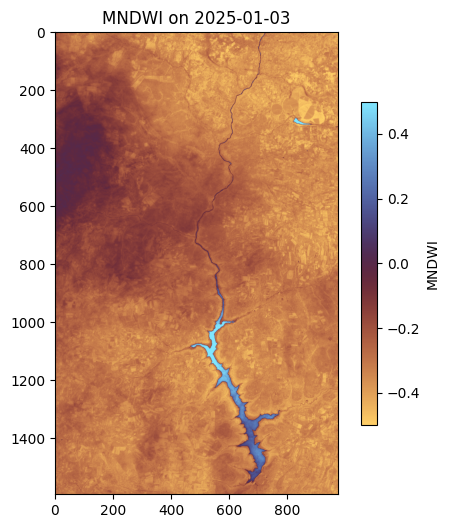

In [18]:
# Plot MNDWI for a specific date as an example
plt.figure(figsize=(6, 6))
plt.imshow(mndwi.sel(time='2025-01-13'), vmin=-0.5, vmax=0.5, cmap='managua')
plt.colorbar(label='MNDWI', shrink=0.7)
plt.title('MNDWI on 2025-01-03');

As shown in the plot (a very clean image), the water body area is clearly visible, with high values represented by the deep sky-blue color.


### 2.2 - Integrate Water Occurrence Data (JRC)


The Global Surface Water Explorer (GSWE) dataset from the European Commission's Joint Research Centre is also used here. This dataset maps the location and temporal distribution of water surfaces at the global scale over the past 32 years and provides statistics on the extent and change of those water surfaces, namely water occurance (WO) probabilities per pixel. So WO actually represents the fraction of time a given pixel was observed as water over the study period. The table below showns the ranges of values and their interpretation generally.


### Interpretation of Pixel Values in GSWE (Water Occurrence Layer)

| **Pixel Value (range)** | **Interpretation** | **Typical Environment** |
|--------------------------|--------------------|--------------------------|
| 0.0                     | Never detected as water during the observation period | Land, desert, urban area |
| 0.1 – 0.5               | Occasionally detected as water (intermittent presence) | Seasonal ponds, floodplains, agricultural fields |
| 0.5 – 0.9               | Frequently water but not permanent | Wetlands, seasonal lakes, riverbanks |
| ~1.0                    | Almost always water (permanent presence) | Lakes, large rivers, reservoirs |

The WO dataset is static. For this exercise, we have stored a subset over our AOI in an S3 bucket, which we will read.  
In general, the dataset can be downloaded [here](https://global-surface-water.appspot.com/download) or accessed through **Google Earth Engine**.

The **GSWE** will be used in the next step to perform some filling over the classified water areas.


In [19]:
ds_wo = rioxarray.open_rasterio("data/water_occurrence_utm35_older_version.tif")


In [20]:
#TODO download the global water occurrence dataset and save it. Then read it here, convert to the utm35 projection and clip to the aoi
# this will show to the users the way to do it rather than using directly the clipped and reporjected version from ee

# ds_wo = hydromt.io.open_raster(R"c:\Users\tsiokano\projects\EOPFL_toolkit\water_occurrence_utm35_older_version.tif")
# ds_wo = rioxarray.open_rasterio(R"c:\Users\tsiokano\projects\EOPFL_toolkit\water_occurrence_utm35_older_version.tif")
ds_wo = rioxarray.open_rasterio("data/water_occurrence_utm35_older_version.tif")

# resample it to match mndwi resolution
ds_wo_matched = ds_wo.rio.reproject_match(
    mndwi,
    resampling=Resampling.nearest
)
ds_wo_matched = ds_wo_matched[0]

# mask out no data values otherwise they appear as 0
# ds_wo_matched = ds_wo_matched.where(ds_wo_matched != ds_wo_matched.rio.nodata)


Visualize example output from Subsection 2.2

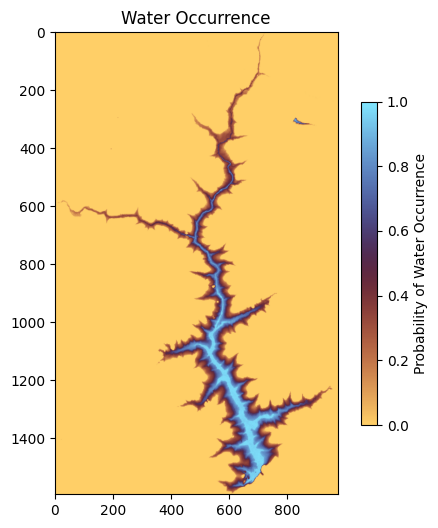

In [69]:
# Plot MNDWI for a specific date as an example
plt.figure(figsize=(6, 6))
plt.imshow(ds_wo_matched, vmin=0, vmax=1, cmap='managua')
plt.colorbar(label='Probability of Water Occurrence', shrink=0.7)
plt.title('Water Occurrence');

As shown in the plot, the main water body has very high probability values, close to one, indicating that these pixels were almost always water during the observation period, representing the permanent water areas of the reservoir. Lower values appear near the edges of the reservoir, which are the most challenging areas to detect. These lower probabilities typically indicate that water was present frequently but not permanently (values around 0.5–0.9) or only occasionally (values around 0.1–0.5). In the next subsection, we will focus on detecting these variable water areas in each image.


### 2.3 - Generate water extents (GWW Algorithm)

To detect water more reliably, we combine two pieces of information as described above: the MNDWI index and the Water Occurrence (WO) dataset.

First, we identify edges in the MNDWI image, which correspond to sharp transitions between water and land. Using only these edge pixels, we apply Otsu thresholding to determine a robust cutoff value that separates water from land. This avoids biases from large uniform land areas and ensures the threshold is focused on transition zones.

Next, we use the WO dataset to fill in water areas that MNDWI might miss, such as shallow or turbid zones. The median of the WO values is computed only on the edge pixels, making the filling threshold context-aware. This filling also helps recover water in pixels obscured by clouds or shadows in the current image. Water is added in areas that are classified as non-water by MNDWI but exceed the WO threshold.

Finally, the water mask from MNDWI and the filled water mask from WO are combined to produce the total water mask.

*The code for the steps described above can be found in the `gww` function.*

In [21]:
water_mask_da, water_fill_da, total_water_da = xr.apply_ufunc(
    gww,
    mndwi,
    ds_wo_matched,
    input_core_dims=[["y", "x"], ["y", "x"]],
    output_core_dims=[["y", "x"], ["y", "x"], ["y", "x"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[bool, bool, bool],
    dask_gufunc_kwargs={"allow_rechunk": True},
)

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 17.79 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


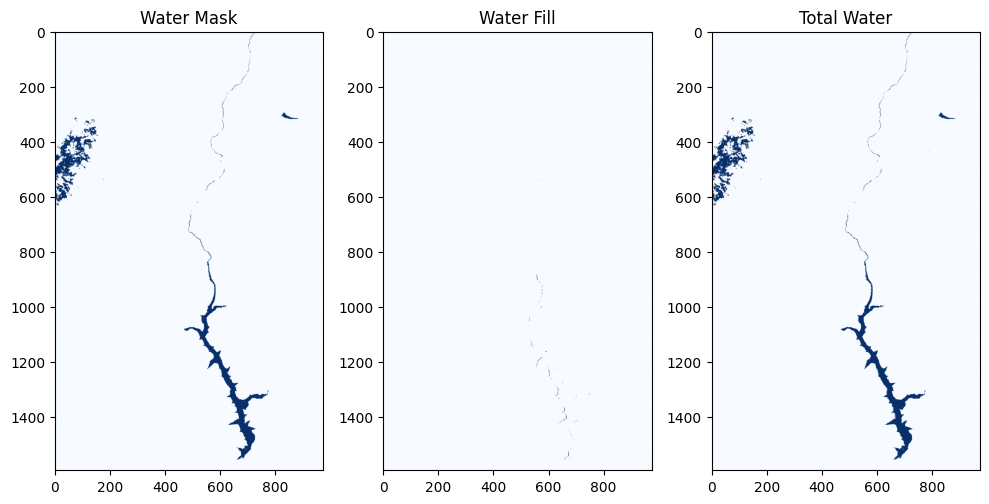

In [21]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(water_mask_da.sel(time='2025-01-13'), cmap='Blues')
plt.title('Water Mask')
# plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(water_fill_da.sel(time='2025-01-13'), cmap='Blues')
plt.title('Water Fill')
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(total_water_da.sel(time='2025-01-13'), cmap='Blues')
plt.title('Total Water')
# plt.axis('off')

plt.tight_layout()
plt.show()

Visualize example output from Subsection 2.3

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 420.97 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


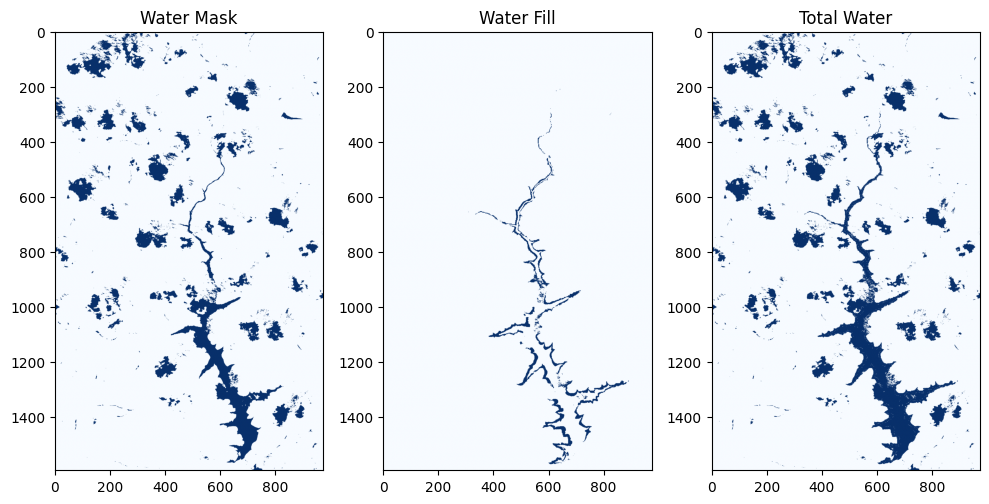

In [61]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(water_mask_da.sel(time="2024-08-21"), cmap='Blues')
plt.title('Water Mask')
# plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(water_fill_da.sel(time="2024-08-21"), cmap='Blues')
plt.title('Water Fill')
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(total_water_da.sel(time="2024-08-21"), cmap='Blues')
plt.title('Total Water')
# plt.axis('off')

plt.tight_layout()
plt.show()

### 2.4 - Extract Largest Connected Component

Even after thresholding, small water patches or noise may appear in the mask. Since we are interested in the main reservoir, we extract the **largest connected component** from the binary water mask. This isolates the primary water body while ignoring smaller, isolated water regions, giving a clean representation of the reservoir. For this we are using the `largest_connected_component` function.

In [22]:
# Largest Connected Component (LCC) filtering on Total Water
lcc_da = xr.apply_ufunc(
    largest_connected_component,
    total_water_da,
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]],
    vectorize=True,  # applies function to each 2D slice
    dask="parallelized",
    output_dtypes=[bool],
)

### 2.5 - Compute Reservoir Area

Finally, we compute the area of the reservoir by counting the number of pixels in the largest water body and converting this count to square kilometers using the pixel size (20 m for our case; see `compute_area_km2` function).

In [23]:
# Compute area in km² of LCC water bodies
area_da = xr.apply_ufunc(
    compute_area_km2,
    lcc_da,
    input_core_dims=[["y", "x"]],
    output_core_dims=[[]],  # scalar per time
    vectorize=True,
    dask="parallelized",
    kwargs={"pixel_size": 20.0},
    output_dtypes=[float],
)

Visualize example output from Subsections 2.4 and 2.5

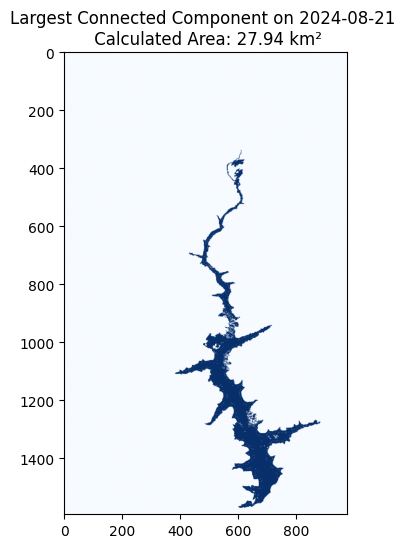

In [62]:
plt.figure(figsize=(6, 6))
plt.imshow(lcc_da.sel(time='2024-08-21'), cmap='Blues')
plt.title(f'Largest Connected Component on 2024-08-21 \n Calculated Area: {area_da.sel(time="2024-08-21").values:.2f} km²');

In [39]:
import os

In [40]:
# GWW data
gww_folder = R"p:\11210554-dtc-hydrology-next\Mita_Hills\reservoir_monitor_EO\gww_ts"
gww_area = pd.read_csv(os.path.join(gww_folder, "Surface Water Area.csv"), index_col=0, parse_dates=True)
gww_area.rename(columns={"Surface Water Area (km2)": "area"}, inplace=True)
gww_volume = pd.read_csv(os.path.join(gww_folder, "Surface Water Volume.csv"), index_col=0, parse_dates=True)
gww_volume.rename(columns={"Surface Water Volume (km3)": "volume"}, inplace=True)
df_gww = pd.merge(gww_area, gww_volume, left_index=True, right_index=True, how='inner')
df_gww["volume"] = df_gww["volume"] * 1e9
df_gww.index = pd.to_datetime(df_gww.index, format='ISO8601')

<Axes: xlabel='time'>

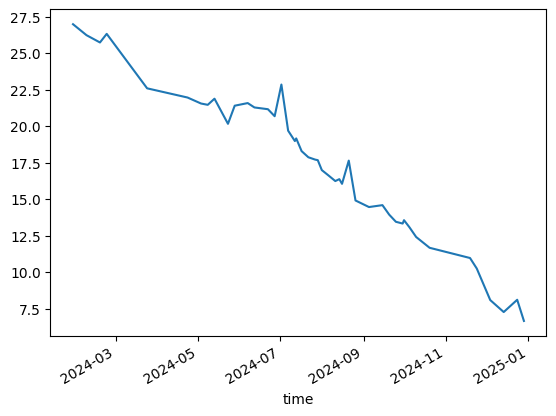

In [47]:
df_gww.loc["2024", "area"].plot()

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 420.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


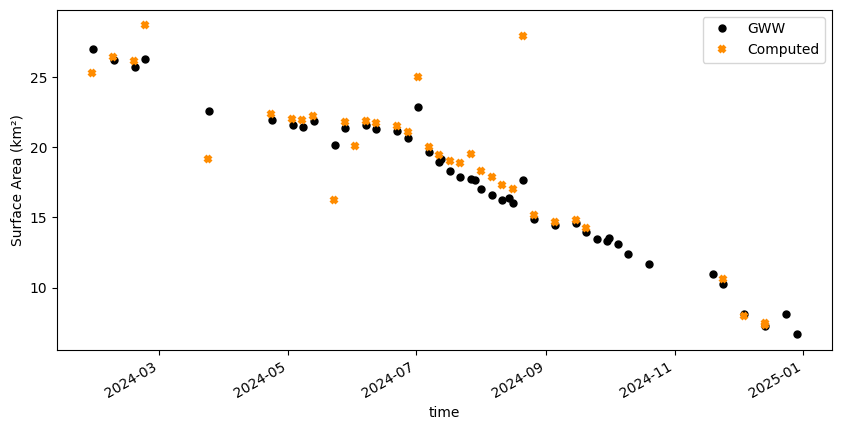

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(df_gww.loc["2024", "area"].index, (df_gww.loc["2024", 'area']), ms=5, marker='o', linestyle=' ', color='k', label="GWW")

area_da.to_pandas().plot(
    marker='x', 
    ms=5,                
    markeredgewidth=3,     
    linestyle=' ', 
    color='darkorange', 
    label="Computed"
)

plt.ylabel('Surface Area (km²)')
plt.legend();

In [55]:
area_da = area_da.compute()

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 420.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [57]:
area_da.sel(time="2024-08-21")

<xarray.DataArray ()> Size: 8B
array(27.9408)
Coordinates:
    time         datetime64[s] 8B 2024-08-21
    spatial_ref  int64 8B 0
    band         int64 8B 1

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 415.04 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


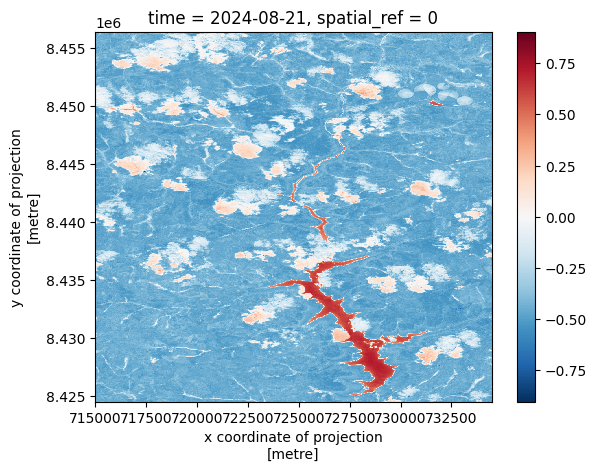

In [60]:
mndwi.sel(time="2024-08-21").plot()

In [63]:
data_cube.sel(time="2024-08-21")

<xarray.Dataset> Size: 25MB
Dimensions:        (y: 1593, x: 975)
Coordinates:
    time           datetime64[s] 8B 2024-08-21
    spatial_ref    int64 8B 0
  * x              (x) float32 4kB 7.15e+05 7.15e+05 ... 7.344e+05 7.345e+05
  * y              (y) float32 6kB 8.456e+06 8.456e+06 ... 8.425e+06 8.425e+06
Data variables:
    green          (y, x) float64 12MB 0.1257 0.1781 0.1183 ... 0.154 0.1523
    swir           (y, x) float64 12MB dask.array<chunksize=(564, 164), meta=np.ndarray>
    quality_score  float64 8B 0.1319

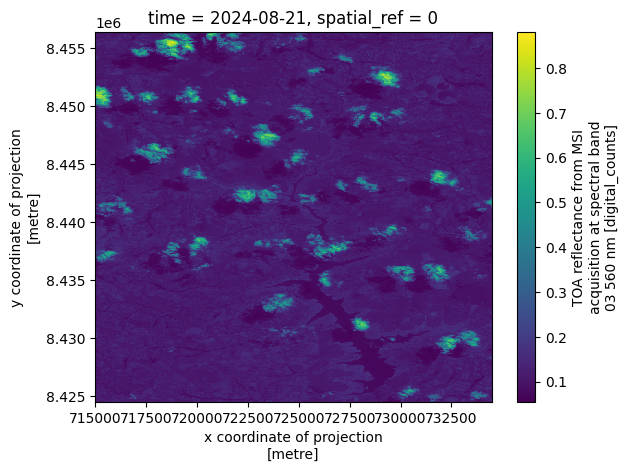

In [59]:
data_cube.sel(time="2024-08-21")["green"].plot()


<hr>

## Challenges

<hr>

## Conclusion

<hr>

## 💪 Now it is your turn


Now that you’re familiar with the reservoir detection workflow, it’s time to put your skills into practice! Below are suggested exercises that scale from replication to comparison and finally to an advanced extension using a different sensor.

**Overview of tasks:**
1. [Try another reservoir](#task-1-try-another-reservoir) – replicate the workflow for a different reservoir.  
2. [Compare with the official GWW algorithm](#task-2-compare-with-the-official-gww-algorithm-via-gwwapi) – analyze differences between our implementation and the GWW API results.  
3. [Explore SAR-based water extent estimation](#task-3-advanced-explore-water-extent-estimation-with-sar-sentinel-1-level-1-grd) – extend the workflow to Sentinel-1 SAR data and compare with optical results.

### Task 1: Try Another Reservoir

**Goal:** test how well the workflow generalizes to a different reservoir.

**Steps:**
1. Visit the [Global Water Watch (GWW) interactive viewer](https://www.globalwaterwatch.earth/map) and explore reservoirs.  
2. Pick a reservoir you find interesting and click **`DOWNLOAD.GEOJSON`** (bottom of the panel) to download its boundary polygon.  
3. Use **GeoPandas** to load the GeoJSON and compute the bounding box (`bbox`) for your new study area.  
4. Re-run this notebook’s processing pipeline using that bounding box.  

**Tips & ideas:**
- Choose reservoirs in different climates (e.g., semi-arid vs. humid tropical) to observe how clouds, vegetation and seasonal changes affect detection.
- Try several sizes: small vs. large reservoirs to see how morphological operations and the largest connected component step behave. Note that usually very large reservoirs are well measured using in-situ measurements and partial observations of surface area are less indicative of the state of the full reservoir.


### Task 2: Compare with the Official GWW Algorithm (via `gwwapi`)

**Goal:** explore differences between the current implementation and the official GWW outputs.

As described in the beggining of this notebook the GWW algorith is much more complex combining many satelite sources. It also uses Normalized Difference Water Index (NDWI) instead of MNDWI and parts of the classification techiques are different for example the largest connected components is not extracted. Also one major difference is that the raw algorith uses a functionality in which the most clean images are selected (using the green band) as well as a long archive is exploited.

**Steps:**
1. Read the GWW API docs: `https://api.globalwaterwatch.earth/docs`.  
2. Install the API:  
   ```bash
   pip install gwwapi
3. Download timeseries for Mita Hills (reservoir id 88643) using hte API
4. Compare GWW's reported water area time series with your own estimates extracted from Sentinel-2 in this notebook.

You can use the following helper function to query the GWW API:

```python
import requests

def get_reservoir_ts_gww(reservoir_id, start_date, end_date):
    """
    Retrieve time series data for a given reservoir ID from the GWW API.
    start_date and end_date are strings in 'YYYY-MM-DD' format.
    """
    base_url = "https://api.globalwaterwatch.earth/v1"
    url = f"{base_url}/reservoir/{reservoir_id}/ts"

    params = {
        "start": f"{start_date}T00:00:00",
        "stop": f"{end_date}T23:59:59"
    }

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    return resp.json()
```

### Task 3 (advanced): Explore water extent estimation with SAR Sentinel-1 Level-1 GRD

**Goal:**  
Adapt the detection workflow you developed for Sentinel-2 optical data to **Sentinel-1 SAR** data, and compare how it performs for the same reservoir.

**Introduction:**

In this notebook, we used **Sentinel-2 L1C optical data** to detect reservoir water extent. The same logic — *Otsu thresholding*, *edge detection*, *morphological filtering*, and *largest connected component extraction* — can also be applied to **Sentinel-1 SAR** data. Since SAR measures **backscatter** instead of reflectance, we can’t compute indices like MNDWI or NDWI. Instead, we use the backscatter values directly to separate wet and dry pixels: water usually appears **dark (e.g. < −16 dB)**. SAR has the advantage of being **cloud-independent**, but can sometimes overestimate water, especially when **dry soil** also produces low backscatter. Also note that SAR requires preprocessing before using it like orbit correction, thermal noise removal, calibration, speckle filtering, terrain correction, conversion to dB etc.

**Steps:**

1. Download and preprocess Sentinel-1 GRD data (see the Flood Mapping - Time Series Analysis in Valencia example).  
2. Adjust the gww function to work with SAR, e.g. apply a simple mask (e.g. `backscatter < -16`), refine with **Otsu thresholding**, use existing morphological steps to clean the result and extract the reservoir (you can skip the water occurance filling).
3. Compare the SAR-based water area with your Sentinel-2 estimates.


<hr>

## What's next?

This online resource is under active development. So stay tuned for regular updates 🛰️.